In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Prelim_sizing_database_revised.csv", sep = ",")
df = df.replace("None", np.nan) # replacing all the None strings to NaN (better for pandas apparently)
df = df.replace("#VALUE!", np.nan)

# converting numerical columns from strings to floats
columns = list(df)
for i in columns[2:8]:
    df[f'{i}'] = pd.to_numeric(df[f'{i}'])

In [2]:
df.head()

,#,Name,TOM,People,Speed,Range,Payload,OEM,Comments
0,1,A2-Cal Aptos Blue,2000.0,3.0,220.0,450.0,NaN,NaN,NaN
1,2,Vahana-Beta,815.0,2.0,230.0,100.0,200.0,NaN,NaN
2,3,ACS Aviation Z-300,1000.0,2.0,222.0,300.0,NaN,NaN,NaN
3,4,Advanced Research Foundation Cyclocar,NaN,6.0,250.0,500.0,600.0,NaN,"Hybrid, payload 600 kg"
4,5,Advanced System Engineering - FIPSI BX4,449.0,2.0,72.0,483.0,NaN,NaN,NaN


In [3]:
mean_squared_error = lambda yreal, ypred: sum((yreal[i] - ypred[i]) ** 2 for i in range(len(yreal))) / len(yreal)
rmse = lambda yreal, ypred: mean_squared_error(yreal, ypred) ** 0.5

<AxesSubplot:xlabel='TOM', ylabel='Range'>

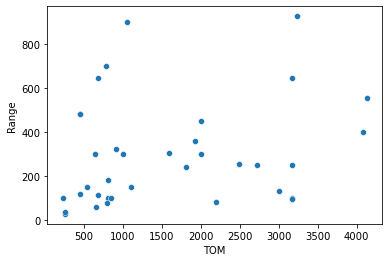

In [4]:
# plotting mtom with range
mass_range = df[['TOM', 'Range']].dropna()
mass_range_filt = mass_range[(mass_range.TOM <5000) & (mass_range.Range < 1000)]
sns.scatterplot(data = mass_range_filt, x = 'TOM', y = 'Range')

<AxesSubplot:xlabel='TOM', ylabel='People'>

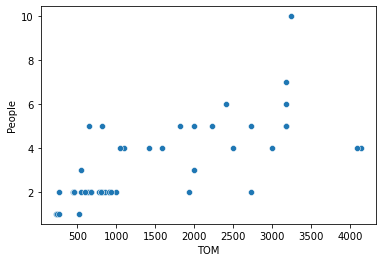

In [5]:
# plotting passengers and weight

pass_mass = df[['People', 'TOM']].dropna()
pass_mass_filt = pass_mass[(pass_mass.TOM < 5000) & (pass_mass.People > 0)]
sns.scatterplot(data = pass_mass_filt, x = 'TOM', y = 'People')

<AxesSubplot:xlabel='Range', ylabel='Speed'>

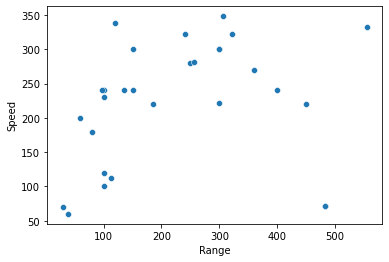

In [6]:
# plotting passengers Range vs Speed
range_speed = df[(df.TOM < 5000) & (df.People > 0)]
range_speed = range_speed[['Range', 'Speed']].dropna()
range_speed_filt = range_speed[(range_speed.Speed < 500) & (range_speed.Range < 600)]
sns.scatterplot(data = range_speed_filt, x = 'Range', y = 'Speed')

In [7]:

def range_cat(range_):
    if range_ < 100:
        return 'Low range'
    if 100 <= range_ < 300:
        return 'Mid range'
    elif 300 <= range_:
        return 'High range'
    else:
        return 'Unknown'

df2 = df 

RMSE: 814.6011453913708
Line equation is: y = 3.948236265055661x + 96.92976490368314


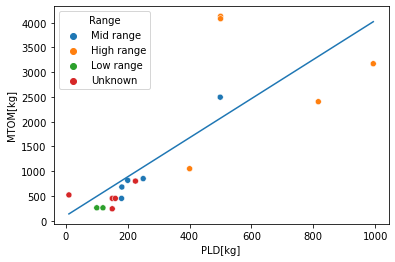

In [8]:
df2['Range'] = df2.Range.apply(range_cat)
TOM_PLD = df2[['TOM', 'Payload', 'Range']].dropna()
# TOM_PLD = TOM_PLD[(TOM_PLD.Range == 'Mid range') | (TOM_PLD.Range == 'High range')]

# # TOM_PLD = TOM_PLD[(TOM_PLD.Range == 'High range')]
y = np.array(TOM_PLD.iloc[:,0])
x = np.array(TOM_PLD.iloc[:,1])
x
m_2, b_2 = np.polyfit(x, y, 1)

print(f'RMSE: {rmse(y, m_2*x+b_2)}')
print(f'Line equation is: y = {m_2}x + {b_2}')
ax = sns.lineplot(x = x , y = m_2*x+b_2)
ax.set_ylabel('MTOM[kg]')
ax.set_xlabel('PLD[kg]')
sns.scatterplot(data = TOM_PLD, x = np.array(TOM_PLD.iloc[:,1]), y = np.array(TOM_PLD.iloc[:,0]), hue = 'Range')
plt.savefig('PLDvsMTOM.png')
# df3 = df[df.TOM > 3000]
# df3[df3.Payload < 600]

RMSE: 166.05120899138262
Line equation is: y = 0.8458723777254168x + -112.45519531400018


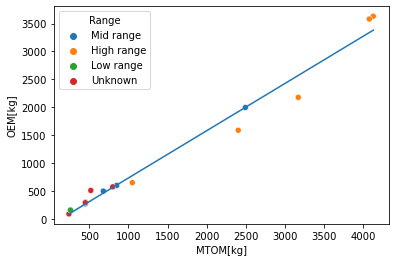

In [9]:
TOM_OEM = df2[['TOM', 'OEM', 'Range']].dropna()
# TOM_OEM = TOM_OEM[(TOM_OEM.Range == 'Mid range') | (TOM_OEM.Range == 'High range')]

# # TOM_PLD = TOM_PLD[(TOM_PLD.Range == 'High range')]
y = np.array(TOM_OEM.iloc[:,1])
x = np.array(TOM_OEM.iloc[:,0])
x
m_1, b_1 = np.polyfit(x, y, 1)

print(f'RMSE: {rmse(y, m_1*x+b_1)}')
print(f'Line equation is: y = {m_1}x + {b_1}')
ax = sns.lineplot(x = x , y = m_1*x+b_1)
ax.set_ylabel('OEM[kg]')
ax.set_xlabel('MTOM[kg]')
sns.scatterplot(data = TOM_OEM, x = np.array(TOM_OEM.iloc[:,0]), y = np.array(TOM_OEM.iloc[:,1]), hue = 'Range')
plt.savefig('OEMvsMTOM.png')

In [10]:
# estimating take-off mass based on payload mass
# the same but for operational empty mass based on take-off mass
req_pld = 5*95
TOM_est = m_2*req_pld + b_2
OEM_est = m_1 * TOM_est + b_1
print(f'Take-off Mass estimate: {TOM_est = } kg,  Operational Empty Mass estimate: {OEM_est = } kg')

Take-off Mass estimate: TOM_est = 1972.3419908051221 kg,  Operational Empty Mass estimate: OEM_est = 1555.8944141360107 kg


In [8]:
# determining design cruise altitude

cities_alt = np.array([929, 837, 810, 802, 718, 700, 698, 695, 686, 
                       683, 667, 665, 664, 660, 652, 649, 623, 600, 
                       594, 580, 574, 568, 542, 519, 518, 516])

avg_alt = cities_alt.mean()
avg_alt += 450
print(f'Design cruise altitude is: {np.round(avg_alt,0)} m')

Design cruise altitude is: 1110.0 m


In [9]:
rho = lambda h: 1.225 * pow(1 - 0.0065 * h / 288.15, 9.81 / (0.0065 * 287) - 1)

Area = lambda WoS, W: W / WoS

design_cruise_speed = lambda rhoair, CL, WoS: (WoS * 2 / (rhoair * CL)) ** 0.5

print(f'{rho(avg_alt) = } kgm^-3')

rho(avg_alt) = 1.099650576194018 kgm^-3


In [10]:
design_dive_speed = lambda Vc: 1.25 * Vc # MOC eVTOL

AspectRatio = lambda S, b: b ** 2 / S 

In [12]:
# %%file gustenv.py
def posgustload(V, Vs, us, ns, CLalpha, WoS):
    n = lambda V, u: 1 + rho(avg_alt) * V * CLalpha * u / (2 * WoS)
    (ub, uc, ud), (Vb, Vc, VD), (nb, nc, nd)  = us, Vs, ns
    interpolate = lambda V, V1, V2, n1, n2: n1 + (V - V1) * (n2 - n1) / (V2 - V1)
    return n(V, ub) if 0 <= V <= Vb else \
    ( interpolate(V, Vb, Vc, nb, nc) if Vb < V <= Vc else interpolate(V, Vc, VD, nc, nd) )

neggustload = lambda V, Vs, us, ns, CLalpha, WoS: 2 - posgustload(V, Vs, us, ns, CLalpha, WoS)

def plotgustenv(Vb, Vc, CLalpha, WoS):
    n = lambda V, u: 1 + rho(avg_alt) * V * CLalpha * u / (2 * WoS)

    Vb, Vc, VD = Vs = (Vb, Vc, design_dive_speed(Vc)) # Change if VD Changes
    ub, uc, ud = us = 20.12, 15.24, 7.62 # Obtained from CS
    nb, nc, nd = ns = n(Vb, ub), n(Vc, uc), n(VD, ud)

    x = np.linspace(0, VD, 100)
    ax = sns.lineplot(x=x, y=[posgustload(V, Vs, us, ns, CLalpha, WoS) for V in x], color='blue')
    ax.set(xlabel="V [m/s]", ylabel="n [-]")
    sns.lineplot(x=x, y=[neggustload(V, Vs, us, ns, CLalpha, WoS) for V in x], color='blue', label='Gust Load Envelope')
    plt.plot([VD, VD], [neggustload(VD, Vs, us, ns, CLalpha, WoS), posgustload(VD, Vs, us, ns, CLalpha, WoS)], color='blue')
    print(f'Maximum load factor is: {np.max([nb,nc,nd])}')
    # plt.savefig('gust.png')

Maximum load factor is: 3.1810623958579414


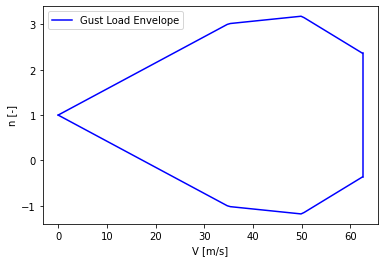

In [17]:
WoS = 826
CLalpha = 4.3
Vc = 50
Vb = Vc * 0.7 # m/s
plotgustenv(Vb, Vc, CLalpha, WoS)

In [13]:
# %%file maneuvre.py

def maneuvrenv(V, Vs, WoS, CLmax, pos=True):
    n = lambda CL, V, WoS: 0.5 * rho(avg_alt) * V ** 2 * CL / WoS
    nmin, nmax = -1, 2.5 # UAM reader
    Vc, VD = Vs
    interpolate = lambda V, V1, V2, n1, n2: n1 + (V - V1) * (n2 - n1) / (V2 - V1)
    return min(n(CLmax, V, WoS), nmax) if pos else \
    ( max(-n(CLmax, V, WoS), nmin) if V <= Vc else interpolate(V, Vc, VD, nmin, 0))

def plotmaneuvrenv(WoS, Vc, CLmax):
    VD = design_dive_speed(Vc)
    Vs = Vc, VD
    x = np.linspace(0, VD, 100)
    ax = sns.lineplot(x=x, y=[maneuvrenv(V, Vs, WoS, CLmax, True) for V in x], color='red')
    sns.lineplot(x=x, y=[maneuvrenv(V, Vs, WoS, CLmax, False) for V in x], color='red', label='Maneuvre Envelope')
    ax.set(xlabel="V [m/s]", ylabel="n [-]")
    plt.plot([VD, VD], [maneuvrenv(VD, Vs, WoS, CLmax, False), maneuvrenv(VD, Vs, WoS, CLmax, True)], color='red')
    # plt.savefig('maneuvre.png')

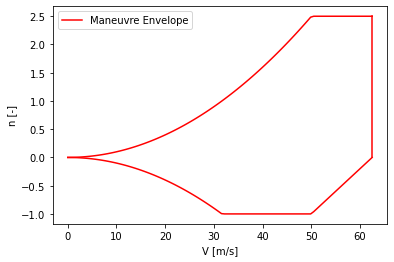

In [19]:
CLmax = 1.5
plotmaneuvrenv(WoS, Vc, CLmax)

Maximum load factor is: 3.4352176189182777


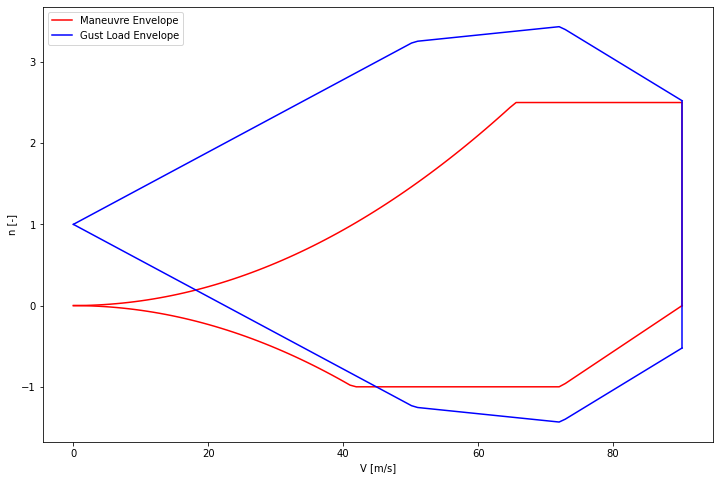

In [14]:
plt.figure(figsize=(12, 8))
plotmaneuvrenv(3024.8 * 9.81 / (9.91 * 2), 72.18, 1.5856)
plotgustenv(0.7 * 72.18, 72.18, 6.028, 3024.8 * 9.81 / (9.91 * 2))
plt.savefig('c3nV.png')